In [1]:
%load_ext rpy2.ipython

In [2]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

In [3]:
import keras_core as keras
from keras_core import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chromax import Simulator, sample_data
import pathlib

Using TensorFlow backend


2023-12-22 19:22:40.241022: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 19:22:40.243053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 19:22:40.283051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 19:22:40.284493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 19:22:41.434553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:

def plot_means_and_variances(dataframes):
    # Calculate the mean and variance for each dataframe
    mean_values = [df.mean() for df in dataframes]
    var_values = [df.var() for df in dataframes]
    var_values = np.array(var_values).flatten()
    mean_values = np.array(mean_values).flatten()

    # Create an array for the x-values
    x_values = range(len(dataframes))

    # Create the scatter plot with error bars
    plt.errorbar(x_values, mean_values, yerr=var_values, fmt='o')

    # Display the plot
    plt.show()


def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects

import numpy as np

def select_random_individuals(arr, num_individuals):
    # Get the shape of the array
    shape = arr.shape

    # Generate random indices along the first axis
    idx = np.random.choice(shape[0], size=num_individuals)

    # Select the random individuals

    return random_individuals

def select_mixed(population, random_split=.99):
  n_pop = population.shape[0]

  n_random = int(n_pop * random_split)
  n_select = int(n_pop * (1-random_split))

  random_parents = select_random_individuals(Farm.current_population, n_random)
  selected_parents = Farm.Simulator.select(Farm.current_population, k = n_select)
  combined_arr = np.concatenate((random_parents, selected_parents), axis=0)
  return combined_arr

def plot_replicate_means_and_variances(replicate_data, start_index=None, end_index=None):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # If start_index or end_index is not provided, set them to default values
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(replicate_data[0])

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Select the dataframes in the specified range
        dataframes = dataframes[start_index:end_index]

        # Calculate the mean and variance for each dataframe
        mean_values = [df.mean() for df in dataframes]
        var_values = [df.var() for df in dataframes]

        # Flatten the var_values and mean_values lists to 1D arrays
        var_values = np.array(var_values).flatten()
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means with error bars for the variances
        ax.errorbar(x_values, mean_values, yerr=var_values, fmt='o', label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


def plot_replicate_means(replicate_data):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Calculate the mean for each dataframe
        mean_values = [df.mean() for df in dataframes]
        # Flatten the mean_values list to a 1D array
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means as a line plot
        ax.plot(x_values, mean_values, label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr
import jax.numpy as jnp
import numpy as np

def score_top(scores: pd.DataFrame, column: str, k: int):
    # Sort the DataFrame from high to low
    sorted_scores = scores.sort_values(by=column, ascending=False)
    # Get the top K indexes
    top_k_indexes = sorted_scores.head(k).index
    return top_k_indexes


def score_top_percentile(scores: pd.DataFrame, column: str, percentile_min: float, percentile_max: float, k: int):
    # Ensure max percentile is greater than min percentile
    assert percentile_max > percentile_min, "Error: max percentile should be greater than min percentile"
    
    # Calculate the percentiles
    lower = scores[column].quantile(percentile_min)
    upper = scores[column].quantile(percentile_max)
    # Filter the DataFrame
    filtered_scores = scores[(scores[column] >= lower) & (scores[column] <= upper)]
    # Sample k random indexes
    sampled_indexes = np.random.choice(filtered_scores.index, k, replace=True)

    return sampled_indexes


In [5]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [6]:
%R -o x

In [7]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [ ]:
# %R install.packages("AlphaSimR")

In [8]:
%%R
library("AlphaSimR")

Loading required package: R6


In [9]:
%%R
founderGenomes = runMacs(nInd = 200,
                         nChr = 3,
                         segSites = 300,
                         species = "MAIZE")

SP = SimParam$new(founderGenomes)
SP$addTraitA(300)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [10]:
%R -o maizeHaplo
%R -o markerEffects
%R -o geneticMap

In [11]:
num_markers = 300
nChr = 3
nInd = 500

In [12]:
reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
reshapeHaplo = reshapeHaplo.transpose((0,2,1))
print(reshapeHaplo.shape)

(200, 900, 2)


In [13]:
chr = parse_markerEffects(markerEffects, nChr)
trait = markerEffects
pos = geneticMap

In [14]:
import pandas as pd

# Assuming chr, trait, pos are your arrays
df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
df

,CHR.PHYS,Yield,cM
0,1,0.004551,0.000000
1,1,-0.005243,0.001667
2,1,-0.003345,0.005103
3,1,-0.000512,0.006147
4,1,-0.005466,0.029012
...,...,...,...
895,3,0.005793,1.965781
896,3,-0.007036,1.966579
897,3,-0.012002,1.983278
898,3,0.008036,1.984637


In [15]:

class BreedingProgram:
    """
    A class to represent a breeding program with a PPO agent
    """
    def __init__(self, init_pop, genetic_map ='random', n_pop = 50, n_markers = 75, generation_max=10, nChr=3, h2=.5):

        self.n_pop = n_pop
        self.n_markers = n_markers

        self.initial_population = init_pop
        if str(genetic_map)=='random':
          self.genetic_map = generate_genetic_map(n_markers=n_markers, n_chromosomes=nChr)
        else:
          self.genetic_map = genetic_map

        self.generation_max = generation_max

        self.Simulator = Simulator(genetic_map = self.genetic_map, h2=h2)
        self.Simulator.load_population(f'mypop.npy')
        self.initial_scores = self.Simulator.GEBV(self.initial_population)
        self.envs = self.Simulator.create_environments(1)
        self.current_generation = 0

        self.history = []

        if self.current_generation == 0:
            self.current_population = self.initial_population
            self.current_scores = self.initial_scores
            self.history.append(self.current_scores)

        else:
            pass

        self.current_selections = [] #list of tuples
        self.current_scores = []

    def write_population(self, filename):
        """
        Write the current population to a file.
        """
        np.save(filename, self.current_population)
        return pathlib.PosixPath(f'/content/{filename}')
    def cycle(self, method, count=1):
      # input : population, method

      for i in range(count):
        self.cycle_once(method)

# phenotyped_scores = Farm.Simulator.phenotype(Farm.current_population)
# topInd = Farm.current_population[score_top(phenotyped_scores, column='Yield', k=40)]
# midInd = Farm.current_population[score_top_percentile(phenotyped_scores, column='Yield', k = 40, percentile_min=.2, percentile_max=.5)]
# np.concatenate((topInd, midInd), axis=0).shape
    def cycle_once(self, method):
      phenotyped_scores = self.Simulator.phenotype(self.current_population)
      if method == 'random':
        new_pop = self.Simulator.random_crosses(self.current_population, n_pop)
      elif method == 'truncation':
        selected_parents = self.current_population[score_top_percentile(phenotyped_scores, column='Yield', k = self.n_pop, percentile_min=.99, percentile_max=1)]
        new_pop = self.Simulator.random_crosses(selected_parents, n_pop)
      elif method == 'mixed':
        topInd = self.current_population[score_top_percentile(phenotyped_scores, column='Yield', k = int(self.n_pop/2), percentile_min=.9, percentile_max=1)]
        midInd = self.current_population[score_top_percentile(phenotyped_scores, column='Yield', k = int(self.n_pop/2), percentile_min=.5, percentile_max=.9)]
        combined_arr = np.concatenate((topInd, midInd), axis=0)
        new_pop = self.Simulator.random_crosses(combined_arr, n_crosses = n_pop, n_offspring=1)
      else:
        pass
      self.current_generation +=1
      self.current_population = new_pop
      self.current_scores = self.Simulator.GEBV(self.current_population)
      self.history.append(self.current_scores)

    def reset_history(self):
      self.history = []
      self.current_generation = 0
      self.current_population = self.initial_population
      self.current_scores = self.initial_scores
      self.history.append(self.current_scores)

In [16]:

#create init population + genetic map
n_pop = nInd
n_markers = num_markers


In [17]:
np.save('mypop', reshapeHaplo)

init_pop = generate_population(n_pop=n_pop, n_markers=n_markers)
#create the breeding program
Farm = BreedingProgram(reshapeHaplo,genetic_map = df, n_pop=n_pop, n_markers=n_markers)
print(f'current pop size: {Farm.current_population.shape}')
print(f'current mean yield : {Farm.Simulator.GEBV(Farm.current_population).mean()}')
#create the input for the actor model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


current pop size: (200, 900, 2)
current mean yield : Yield   -0.400138
dtype: float32


In [18]:
Farm = BreedingProgram(reshapeHaplo,genetic_map = df, n_pop=n_pop, n_markers=n_markers)

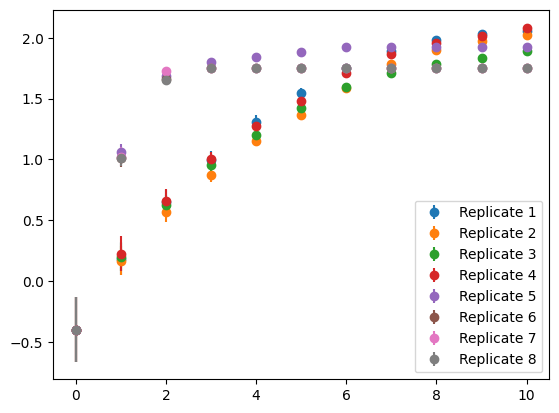

In [19]:
replicate_data = []
reps=4

cycle_total = 10

Farm = BreedingProgram(reshapeHaplo,genetic_map = df, n_pop=n_pop, n_markers=n_markers, h2=.93)
envs = Farm.Simulator.create_environments(1)

for i in (range(reps)):
    Farm.cycle(method='mixed', count=cycle_total)
    replicate_data.append(Farm.history)
    Farm.reset_history()

for i in (range(reps)):
    Farm.cycle(method='truncation', count=cycle_total)
    replicate_data.append(Farm.history)
    Farm.reset_history()

plot_replicate_means_and_variances(replicate_data)

In [25]:
Farm.current_population.shape

(200, 900, 2)

In [26]:
a_reshaped = Farm.current_population.reshape((200,1800))

In [28]:
a_reshaped.shape

(200, 1800)

In [34]:
# Define the number of epochs and the learning rate
epochs = 10
learning_rate = 0.01

# Define the policy network
inputs = keras.Input(shape=(200, 1800))
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(400, activation='softmax')(x)

policy_model = keras.Model(inputs=inputs, outputs=outputs)


# Define the optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer and a suitable loss function
policy_model.compile(optimizer=optimizer, loss='categorical_crossentropy')




In [35]:
import numpy as np

# Create a random example
example = np.random.rand(1, 200, 1800)

# Send the example through the policy network
action_probabilities = policy_model.predict(example)


2023-12-22 19:30:33.663895: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdb900093e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-22 19:30:33.663997: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-22 19:30:33.759545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2023-12-22 19:30:34.268591: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [38]:
action_probabilities[0].shape

(200, 400)